In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterGrid

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import VotingClassifier




from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ReelView = pd.read_csv('/content/drive/MyDrive/csv files/ReelView.csv')
movies_metadata = pd.read_csv('/content/drive/MyDrive/csv files/movies_metadata.csv')
keywords = pd.read_csv('/content/drive/MyDrive/csv files/keywords.csv')
links = pd.read_csv('/content/drive/MyDrive/csv files/links.csv')
links_small = pd.read_csv('/content/drive/MyDrive/csv files/links_small.csv')
ratings_small = pd.read_csv('/content/drive/MyDrive/csv files/ratings_small.csv')
box_office = pd.read_csv('/content/drive/MyDrive/csv files/boxoffice.csv')
BestBooks = pd.read_csv('/content/drive/MyDrive/csv files/books_1.Best_Books_Ever.csv')
best_selling_books = pd.read_csv('/content/drive/MyDrive/csv files/best-selling-books.csv')
ratings = pd.read_csv('/content/drive/MyDrive/csv files/ratings.csv')
author = pd.read_csv('/content/drive/MyDrive/csv files/author_info.csv')

<ipython-input-3-c18f3cb1a0f9>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata = pd.read_csv('/content/drive/MyDrive/csv files/movies_metadata.csv')


**Book Datasets**
1.   **BestBooks**: This dataset provides comprehensive information about 52478 books on Goodreads' Best Books Ever list, including ratings, genres, awards, and more
2.   **best_selling_books**: This dataset contains lists of best-selling books and book series in any language.


**Movie Datasets**
1.   **ReelView**: movie reviews from ReelView
2.   **movies_metadata**: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.
3. **keywords**: Contains the movie plot keywords for our MovieLens movies
4. **links**: The file that contains the TMDB and IMDB IDs of all the movies featured in the Full MovieLens dataset.
5. **links_small**: Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.
6. **ratings_small**: The subset of 100,000 ratings from 700 users on 9,000 movies.


In [4]:
#adding a number of awards column into BestBooks dataframe
#dropping duplicates of the same book and movie
#adding suffix to each frame so we can keep track on what columns are about the book and what about the movie
BestBooks['award list'] = BestBooks['awards'].str.split(',')
BestBooks['num book awards'] = BestBooks['award list'].str.len()

BestBooks = BestBooks.drop_duplicates(subset='title')
movies_metadata = movies_metadata.drop_duplicates(subset='title')

BestBooks.columns = ['book_' + col if col != 'title' else col for col in BestBooks.columns]
movies_metadata.columns = ['movie_' + col if col != 'title' else col for col in movies_metadata.columns]

In [5]:

#merging the books and movies
#removing all columns that are not good for our model
#replace NaN values with appropriate values
#making sure the publish date type is coherent
#dropped all NaN rows since they were only 16 of them

df = pd.merge(BestBooks, movies_metadata, on='title')

df['book_firstPublishDate'] = df['book_firstPublishDate'].fillna(df['book_publishDate'])
df['book_pages'] = df['book_pages'].str.extract('(\d+)')
df['book_pages'] = df['book_pages'].fillna(np.median(df['book_pages'].dropna().astype(int)))
df['book_publish_date'] = pd.to_datetime(df['book_firstPublishDate'], errors='coerce', exact=False)

df = df.drop(columns=['book_bookId', 'book_series', 'book_description', 'book_isbn', 'book_language', 'book_edition',
                      'movie_production_countries', 'book_characters', 'book_bookFormat', 'movie_original_title',
                      'movie_spoken_languages', 'movie_status', 'movie_video', 'movie_tagline', 'movie_overview',
                      'movie_poster_path', 'movie_production_companies', 'movie_homepage', 'movie_id',
                      'book_coverImg', 'book_bbeScore', 'book_bbeVotes', 'book_price', 'book_award list',
                      'movie_adult', 'movie_belongs_to_collection', 'movie_original_language', 'movie_popularity',
                      'movie_runtime', 'book_publisher', 'book_publishDate', 'book_firstPublishDate'], axis=1)
df = df.dropna()

In [6]:
#Making sure the book came out before the movie
df = df[df['movie_release_date'] > df['book_publish_date'] + pd.DateOffset(years=1)]

In [7]:
#adding lifetime gross and studio
df = pd.merge(df, box_office[['title', 'studio' , 'lifetime_gross']], on='title', how='left')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1434 entries, 0 to 1433
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   title                 1434 non-null   object        
 1   book_author           1434 non-null   object        
 2   book_rating           1434 non-null   float64       
 3   book_genres           1434 non-null   object        
 4   book_pages            1434 non-null   object        
 5   book_awards           1434 non-null   object        
 6   book_numRatings       1434 non-null   int64         
 7   book_ratingsByStars   1434 non-null   object        
 8   book_likedPercent     1434 non-null   float64       
 9   book_setting          1434 non-null   object        
 10  book_num book awards  1434 non-null   int64         
 11  movie_budget          1434 non-null   object        
 12  movie_genres          1434 non-null   object        
 13  movie_imdb_id     

In [9]:
df = df.dropna()

In [10]:
#adding author information such as workcount, fancount and gender

df['book_author'] = df['book_author'].str.lower()
df['book_author'] = df['book_author'].str.split(',').str[0]
df['book_author'] = df['book_author'].str.replace(r"\(.*\)", "", regex=True).str.strip()
df['book_author'] = df['book_author'].astype(str)

author['name'] = author['name'].str.lower()
author['name'] = author['name'].str.split(',').str[0]
author['name'] = author['name'].str.replace(r"\(.*\)", "", regex=True).str.strip()
author['name'] = author['name'].astype(str)

df = pd.merge(df, author[['name', 'workcount', 'fan_count']], left_on='book_author', right_on='name', how='left')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 821 entries, 0 to 820
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   title                 821 non-null    object        
 1   book_author           821 non-null    object        
 2   book_rating           821 non-null    float64       
 3   book_genres           821 non-null    object        
 4   book_pages            821 non-null    object        
 5   book_awards           821 non-null    object        
 6   book_numRatings       821 non-null    int64         
 7   book_ratingsByStars   821 non-null    object        
 8   book_likedPercent     821 non-null    float64       
 9   book_setting          821 non-null    object        
 10  book_num book awards  821 non-null    int64         
 11  movie_budget          821 non-null    object        
 12  movie_genres          821 non-null    object        
 13  movie_imdb_id       

In [12]:
#filling NaN values

df['author_workcount'] = df['workcount'].fillna(df['workcount'].mean())
df['author_fan_count'] = df['fan_count'].fillna(df['fan_count'].mean())
df = df.drop(columns=['name', 'workcount', 'fan_count'], axis=1)

In [13]:
#creating a column with the quantile for each value in the numerical columns
col_names = df.quantile(np.arange(.01, 1.01, .01)).columns
quantiles = df.quantile(np.arange(0.01, 1.01, 0.01))
# Iterate through columns
for col in col_names:
    success = []
    # Iterate through elements in the column
    for a in df[col].values:
        # Find the index of the first quantile where the element is smaller
        index = (quantiles[col] > a).idxmax()
        success.append(index)
    # Create a new column with success values
    df['success_' + col] = success

<ipython-input-13-3d27fe7da933>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  col_names = df.quantile(np.arange(.01, 1.01, .01)).columns
<ipython-input-13-3d27fe7da933>:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quantiles = df.quantile(np.arange(0.01, 1.01, 0.01))


In [14]:
df.columns

Index(['title', 'book_author', 'book_rating', 'book_genres', 'book_pages',
       'book_awards', 'book_numRatings', 'book_ratingsByStars',
       'book_likedPercent', 'book_setting', 'book_num book awards',
       'movie_budget', 'movie_genres', 'movie_imdb_id', 'movie_release_date',
       'movie_revenue', 'movie_vote_average', 'movie_vote_count',
       'book_publish_date', 'studio', 'lifetime_gross', 'author_workcount',
       'author_fan_count', 'success_book_rating', 'success_book_numRatings',
       'success_book_likedPercent', 'success_book_num book awards',
       'success_movie_revenue', 'success_movie_vote_average',
       'success_movie_vote_count', 'success_lifetime_gross',
       'success_author_workcount', 'success_author_fan_count'],
      dtype='object')

In [15]:
#making an average success metric of .01 through 1
book_success_cols = ['success_book_rating',
       'success_book_numRatings', 'success_book_likedPercent',
       'success_book_num book awards','success_author_fan_count',
       'success_author_workcount']

#removing success_movie_revenue since there are lots of 0s
movie_success_cols = ['success_movie_vote_average', 'success_movie_vote_count',
       'success_lifetime_gross']
#removing average vote of 0 (8 movies)
df = df[df['movie_vote_average']!=0]

#removing movies with no votes (8 movies)
df = df[df['movie_vote_count']!=0]

df['avg_book_success'] = df[book_success_cols].mean(axis=1)
df['avg_movie_success'] = df[movie_success_cols].mean(axis=1)

In [16]:

df.columns

Index(['title', 'book_author', 'book_rating', 'book_genres', 'book_pages',
       'book_awards', 'book_numRatings', 'book_ratingsByStars',
       'book_likedPercent', 'book_setting', 'book_num book awards',
       'movie_budget', 'movie_genres', 'movie_imdb_id', 'movie_release_date',
       'movie_revenue', 'movie_vote_average', 'movie_vote_count',
       'book_publish_date', 'studio', 'lifetime_gross', 'author_workcount',
       'author_fan_count', 'success_book_rating', 'success_book_numRatings',
       'success_book_likedPercent', 'success_book_num book awards',
       'success_movie_revenue', 'success_movie_vote_average',
       'success_movie_vote_count', 'success_lifetime_gross',
       'success_author_workcount', 'success_author_fan_count',
       'avg_book_success', 'avg_movie_success'],
      dtype='object')

In [17]:
#removing all columns not used for model
df = df.drop(columns=[ 'movie_genres', 'movie_imdb_id', 'movie_release_date', 'movie_budget',
                      'movie_revenue', 'movie_vote_average', 'movie_vote_count', 'lifetime_gross',
                 'success_book_rating', 'success_book_numRatings', 'success_book_likedPercent',
                 'success_book_num book awards', 'success_movie_revenue', 'success_movie_vote_average',
                'success_movie_vote_count', 'success_lifetime_gross', 'success_author_workcount',
                 'success_author_fan_count', 'studio', 'book_ratingsByStars', 'book_setting', 'book_awards',
                      'avg_book_success'], axis=1)

In [18]:
#add year column
df['book_publish_year'] = df['book_publish_date'].dt.year
df = df.drop(['book_publish_date'], axis=1)

#encode author col
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Author Encoded'] = label_encoder.fit_transform(df['book_author'])
df = df.drop(['book_author'], axis=1)

In [19]:
#find most common genres and one hot encode them
from collections import Counter
import ast

df['book_genres'] = df['book_genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

genre_counts = Counter([genre for sublist in df['book_genres'] for genre in sublist])
genres_over_60 = {genre: count for genre, count in genre_counts.items() if count > 60}
most_common_genres = genres_over_60.keys()
df['genres'] = df['book_genres'].apply(lambda genres: [genre for genre in genres if genre in most_common_genres])
exploded_genres = df.explode('genres')

encoded_genres = pd.get_dummies(exploded_genres['genres'])
final_encoded_genres = encoded_genres.groupby(level=0).sum()
final_df = pd.concat([df, final_encoded_genres], axis=1)
df = final_df.drop(['genres', 'book_genres'], axis=1)
df.set_index('title', inplace=True)

In [20]:
most_common_genres

dict_keys(['Young Adult', 'Fiction', 'Fantasy', 'Science Fiction', 'Romance', 'Adventure', 'Childrens', 'Audiobook', 'Classics', 'Historical Fiction', 'Historical', 'Humor', 'Novels', 'Mystery', 'Thriller', 'Suspense', 'Mystery Thriller', 'Crime', 'Adult', 'Adult Fiction', 'Contemporary', 'Chick Lit', 'Drama', 'Literature', 'Nonfiction', 'Paranormal', 'Horror', 'Literary Fiction', 'American'])

In [21]:
df.rename(columns={'book_rating': 'Rating', 'book_pages' : 'Num of Pages',
                   'book_numRatings' : 'Total Ratings', 'book_likedPercent': 'Percent Liked',
                   'book_num book awards': 'Num of Awards', 'author_workcount': 'Author Workcount',
                   'author_fan_count': 'Author Fancount', 'avg_movie_success': 'Movie Success'}, inplace=True)

In [22]:
df

,Rating,Num of Pages,Total Ratings,Percent Liked,Num of Awards,Author Workcount,Author Fancount,Movie Success,book_publish_year,Author Encoded,...,Mystery,Mystery Thriller,Nonfiction,Novels,Paranormal,Romance,Science Fiction,Suspense,Thriller,Young Adult
title,,,,,,,,,,,,,,,,,,,,,
The Hunger Games,4.33,374,6376780,96.0,41,32.0,81311.0,0.580000,2008,568,...,0,0,0,0,0,1,1,0,0,1
Harry Potter and the Order of the Phoenix,4.50,870,2507623,98.0,9,242.0,209174.0,0.963333,2003,227,...,0,0,0,0,0,0,0,0,0,1
The Book Thief,4.37,552,1834276,96.0,20,16.0,33743.0,0.806667,2005,395,...,0,0,0,0,0,0,0,0,0,1
The Hitchhiker's Guide to the Galaxy,4.22,193,1436325,94.0,1,103.0,19029.0,0.756667,1979,150,...,0,0,0,1,0,0,1,0,0,0
The Da Vinci Code,3.86,489,1933446,89.0,9,76.0,81601.0,0.826667,2003,113,...,1,1,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Risk,3.53,176,345,88.0,1,30.0,110.0,0.346667,2009,102,...,1,0,0,0,0,0,0,0,1,0
Savannah,4.17,608,2007,95.0,1,56.0,134.0,0.166667,1983,174,...,0,0,0,0,0,1,0,0,0,0
Last Orders,3.68,352,12451,89.0,4,41.0,429.0,0.303333,1996,198,...,0,0,0,1,0,0,0,0,0,0


In [23]:
df.columns


Index(['Rating', 'Num of Pages', 'Total Ratings', 'Percent Liked',
       'Num of Awards', 'Author Workcount', 'Author Fancount', 'Movie Success',
       'book_publish_year', 'Author Encoded', 'Adult', 'Adult Fiction',
       'Adventure', 'American', 'Audiobook', 'Chick Lit', 'Childrens',
       'Classics', 'Contemporary', 'Crime', 'Drama', 'Fantasy', 'Fiction',
       'Historical', 'Historical Fiction', 'Horror', 'Humor',
       'Literary Fiction', 'Literature', 'Mystery', 'Mystery Thriller',
       'Nonfiction', 'Novels', 'Paranormal', 'Romance', 'Science Fiction',
       'Suspense', 'Thriller', 'Young Adult'],
      dtype='object')

In [24]:

# Define criteria for categorizing movie success
def categorize_movie_success(success_value):
    if success_value >= threshold_for_hit:
        return 'hit'
    elif threshold_for_flop <= success_value < threshold_for_hit:
        return 'average'
    else:
        return 'flop'

# Set the thresholds based on the criteria
threshold_for_hit = 0.8  # threshold for a 'hit'
threshold_for_flop = 0.2  # threshold for a 'flop'

# Apply the categorization function to create a new column 'Movie Success Category'
df['Movie Success Category'] = df['Movie Success'].apply(categorize_movie_success)


df = df.drop(['Movie Success'], axis=1)
df = df.drop(['Author Encoded'], axis=1)
df = df.drop(['Percent Liked'], axis=1)


In [25]:
df['Num of Pages'] = pd.to_numeric(df['Num of Pages'], errors='coerce')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 813 entries, The Hunger Games to The Rachel Papers
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Rating                  813 non-null    float64
 1   Num of Pages            813 non-null    float64
 2   Total Ratings           813 non-null    int64  
 3   Num of Awards           813 non-null    int64  
 4   Author Workcount        813 non-null    float64
 5   Author Fancount         813 non-null    float64
 6   book_publish_year       813 non-null    int64  
 7   Adult                   813 non-null    uint8  
 8   Adult Fiction           813 non-null    uint8  
 9   Adventure               813 non-null    uint8  
 10  American                813 non-null    uint8  
 11  Audiobook               813 non-null    uint8  
 12  Chick Lit               813 non-null    uint8  
 13  Childrens               813 non-null    uint8  
 14  Classics          

In [27]:
df.head()

,Rating,Num of Pages,Total Ratings,Num of Awards,Author Workcount,Author Fancount,book_publish_year,Adult,Adult Fiction,Adventure,...,Mystery Thriller,Nonfiction,Novels,Paranormal,Romance,Science Fiction,Suspense,Thriller,Young Adult,Movie Success Category
title,,,,,,,,,,,,,,,,,,,,,
The Hunger Games,4.33,374.0,6376780,41,32.0,81311.0,2008,0,0,1,...,0,0,0,0,1,1,0,0,1,average
Harry Potter and the Order of the Phoenix,4.50,870.0,2507623,9,242.0,209174.0,2003,0,0,1,...,0,0,0,0,0,0,0,0,1,hit
The Book Thief,4.37,552.0,1834276,20,16.0,33743.0,2005,0,0,0,...,0,0,0,0,0,0,0,0,1,hit
The Hitchhiker's Guide to the Galaxy,4.22,193.0,1436325,1,103.0,19029.0,1979,0,0,1,...,0,0,1,0,0,1,0,0,0,average
The Da Vinci Code,3.86,489.0,1933446,9,76.0,81601.0,2003,1,0,1,...,1,0,1,0,0,0,1,1,0,hit


In [28]:
#Feature Scaling
df['Total Ratings'] = df['Total Ratings'].apply(lambda x: (x - np.average(df['Total Ratings']))\
                                            / np.std(df['Total Ratings']))
df['Author Fancount'] = df['Author Fancount'].apply(lambda x: (x - np.average(df['Author Fancount']))\
                                            / np.std(df['Author Fancount']))
df['Author Workcount'] = df['Author Workcount'].apply(lambda x: (x - np.average(df['Author Workcount']))\
                                            / np.std(df['Author Workcount']))

<ipython-input-29-59a22f9da00d>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


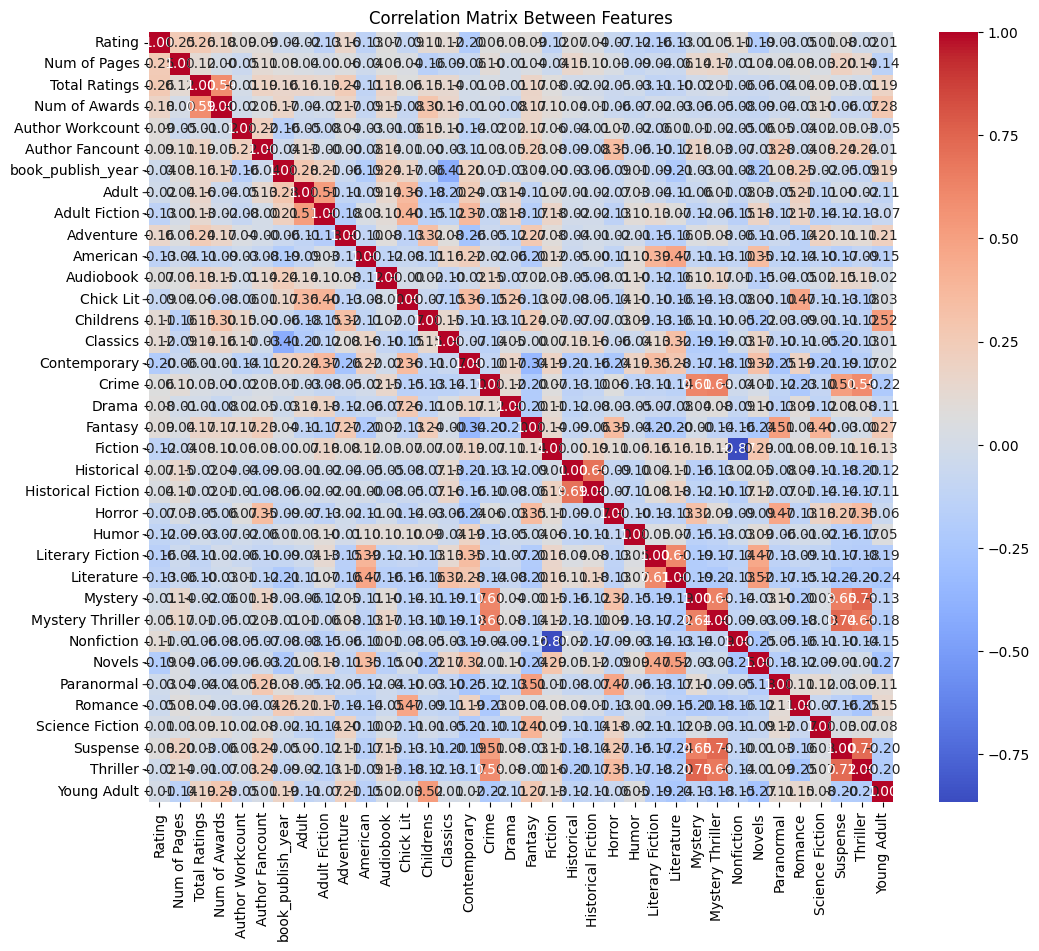

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the features
# Replace 'df' with the actual DataFrame name

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Customize the plot
plt.title('Correlation Matrix Between Features')
plt.show()

In [30]:
df

,Rating,Num of Pages,Total Ratings,Num of Awards,Author Workcount,Author Fancount,book_publish_year,Adult,Adult Fiction,Adventure,...,Mystery Thriller,Nonfiction,Novels,Paranormal,Romance,Science Fiction,Suspense,Thriller,Young Adult,Movie Success Category
title,,,,,,,,,,,,,,,,,,,,,
The Hunger Games,4.33,374.0,13.548081,41,-0.199913,0.458034,2008,0,0,1,...,0,0,0,0,1,1,0,0,1,average
Harry Potter and the Order of the Phoenix,4.50,870.0,5.098175,9,0.015055,1.612664,2003,0,0,1,...,0,0,0,0,0,0,0,0,1,hit
The Book Thief,4.37,552.0,3.627643,20,-0.216291,0.028485,2005,0,0,0,...,0,0,0,0,0,0,0,0,1,hit
The Hitchhiker's Guide to the Galaxy,4.22,193.0,2.758552,1,-0.127233,-0.104385,1979,0,0,1,...,0,0,1,0,0,1,0,0,0,average
The Da Vinci Code,3.86,489.0,3.844221,9,-0.154872,0.460653,2003,1,0,1,...,1,0,1,0,0,0,1,1,0,hit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Risk,3.53,176.0,-0.377505,1,-0.201960,-0.275228,2009,0,0,0,...,0,0,0,0,0,0,0,1,0,average
Savannah,4.17,608.0,-0.373875,1,-0.175345,-0.275011,1983,1,0,0,...,0,0,0,0,1,0,0,0,0,flop
Last Orders,3.68,352.0,-0.351066,4,-0.190700,-0.272347,1996,0,0,0,...,0,0,1,0,0,0,0,0,0,average


In [31]:
from sklearn.model_selection import train_test_split


X = df.drop('Movie Success Category', axis=1)  # Features
y = df['Movie Success Category']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Model building and evaluation
create_params = {'max_iter': 1000, 'random_state': 42, 'alpha': 1,
                 'activation': 'logistic', 'solver': 'adam',
                 'hidden_layer_sizes': (50, 100), 'learning_rate_init': 0.002,
                 'batch_size': 256}
model_mlp = MLPClassifier(**create_params)

model_mlp.fit(X_train, y_train)

# Predict on the training set
y_pred_train = model_mlp.predict(X_train)

# Calculate accuracy on the training set
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f'Train accuracy: {accuracy_train * 100:.2f}%')

# Predict on the test set
y_pred_test = model_mlp.predict(X_test)

# Calculate accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Test accuracy: {accuracy_test * 100:.2f}%')

Train accuracy: 79.38%
Test accuracy: 74.85%


In [33]:
model_gb = GradientBoostingClassifier(learning_rate=0.05, max_depth=7,
                                      max_features=0.5,
                                      min_samples_leaf=110,
                                    n_estimators=300, random_state = 42)
model_gb.fit(X_train, y_train)

# Predict on the training set
y_pred_train_gb = model_gb.predict(X_train)

# Calculate accuracy on the training set
accuracy_train_gb = accuracy_score(y_train, y_pred_train_gb)
print(f'Train accuracy (Gradient Boosting): {accuracy_train_gb * 100:.2f}%')

# Predict on the test set
y_pred_test_gb = model_gb.predict(X_test)

# Calculate accuracy on the test set
accuracy_test_gb = accuracy_score(y_test, y_pred_test_gb)
print(f'Test accuracy (Gradient Boosting): {accuracy_test_gb * 100:.2f}%')

Train accuracy (Gradient Boosting): 86.00%
Test accuracy (Gradient Boosting): 76.07%


In [34]:
model_rf = RandomForestClassifier(n_estimators=150, random_state=42)

model_rf.fit(X_train, y_train)

# Predict on the training set
y_pred_train_rf = model_rf.predict(X_train)

# Calculate accuracy on the training set
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
print(f'Train accuracy (Random Forest): {accuracy_train_rf * 100:.2f}%')

# Predict on the test set
y_pred_test_rf = model_rf.predict(X_test)

# Calculate accuracy on the test set
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)
print(f'Test accuracy (Random Forest): {accuracy_test_rf * 100:.2f}%')

Train accuracy (Random Forest): 99.85%
Test accuracy (Random Forest): 76.07%


In [35]:
model_adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=11))

model_adaboost.fit(X_train, y_train)


# Predict on the training set
y_pred_train_adaboost = model_adaboost.predict(X_train)

# Calculate accuracy on the training set
accuracy_train_adaboost = accuracy_score(y_train, y_pred_train_adaboost)
print(f'Train accuracy (AdaBoost): {accuracy_train_adaboost * 100:.2f}%')

# Predict on the test set
y_pred_test_adaboost = model_adaboost.predict(X_test)

# Calculate accuracy on the test set
accuracy_test_adaboost = accuracy_score(y_test, y_pred_test_adaboost)
print(f'Test accuracy (AdaBoost): {accuracy_test_adaboost * 100:.2f}%')

Train accuracy (AdaBoost): 99.85%
Test accuracy (AdaBoost): 74.85%


In [36]:
# Create a Voting Classifier
ensemble_model = VotingClassifier(estimators=[
    ('mlp', model_mlp),
    ('gb', model_gb),
    ('rf', model_rf),
    ('adaboost', model_adaboost)], voting='soft')


ensemble_model.fit(X_train, y_train)

# Predict on the test set
y_pred_test_ensemble = ensemble_model.predict(X_test)

# Calculate accuracy on the test set
accuracy_test_ensemble = accuracy_score(y_test, y_pred_test_ensemble)
print(f'Test accuracy (Ensemble): {accuracy_test_ensemble * 100:.2f}%')

Test accuracy (Ensemble): 76.69%
